In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import PIL.Image

In [3]:
foldername = "./results/sub05_results_nopre10000/validation_results/"
fnames = glob.glob(foldername + '*.npy')
print(fnames)

['./results/sub05_results_nopre10000/validation_results\\val_probabilities_1.npy', './results/sub05_results_nopre10000/validation_results\\val_probabilities_2.npy', './results/sub05_results_nopre10000/validation_results\\val_probabilities_3.npy', './results/sub05_results_nopre10000/validation_results\\val_probabilities_4.npy', './results/sub05_results_nopre10000/validation_results\\val_probabilities_5.npy']


# Visualize the effect of varying the threshold of probability for the clasification

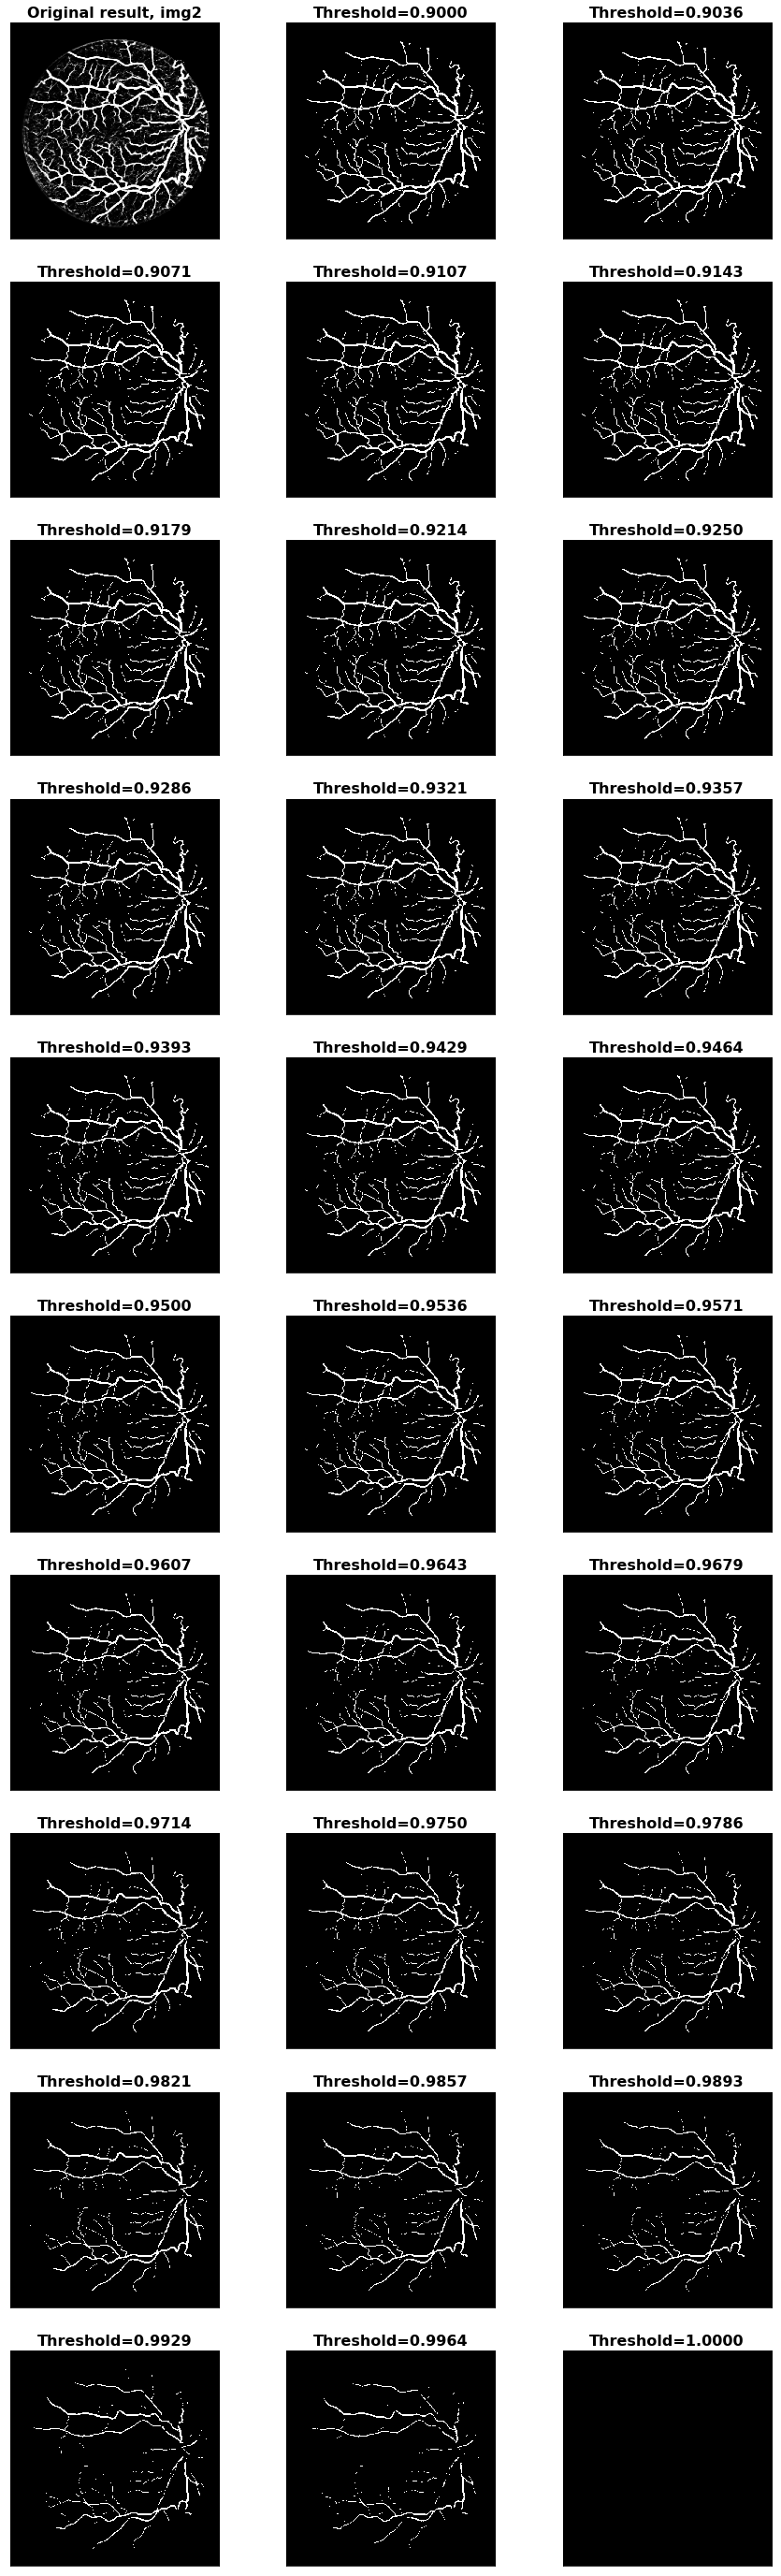

In [4]:
plt.rcParams["figure.figsize"] = (15,50)

limit = np.linspace(0.9, 1.0, 29)
nrows = (len(limit)+1) / 3
ncols = 3
num_img = 2
probimage = np.load(fnames[num_img])


# Continuous prediction
plt.subplot(nrows, ncols, 1)
plt.imshow(probimage, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title(f"Original result, img{num_img}", fontsize=16, fontweight="bold")

# Thresholded
for i in range(len(limit)):
    plt.subplot(nrows, ncols, i+2)
    thres_image = copy.deepcopy(probimage)
    thres_image[thres_image>limit[i]*np.amax(probimage)] = 1
    thres_image[thres_image<=limit[i]*np.amax(probimage)] = 0
    plt.imshow(thres_image, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Threshold={limit[i]:.4f}", fontsize=16, fontweight="bold")

plt.show()

In [5]:
# Load the ground truth segmentations
import random
random.seed(0)

impaths_all = glob.glob(r'.\training\images\*.tif')

#shuffle the images to take a random subset for training later
random.shuffle(impaths_all)

maskpaths_all = copy.deepcopy(impaths_all)
segpaths_all = copy.deepcopy(impaths_all)

#select the corresponding masks and segmentations
for i in range(len(impaths_all)):
    maskpaths_all[i] = impaths_all[i].replace('images','mask')
    maskpaths_all[i] = maskpaths_all[i].replace('.tif','_mask.gif')

    segpaths_all[i] = impaths_all[i].replace('images','1st_manual')
    segpaths_all[i] = segpaths_all[i].replace('training.tif','manual1.gif')

print(impaths_all)
print(maskpaths_all)
print(segpaths_all)


#validate the trained network on the 5 images that were left out during training (numbers 15 to 19)
trainingsetsize=15
valimpaths = impaths_all[trainingsetsize:]
valmaskpaths = maskpaths_all[trainingsetsize:]
valsegpaths = segpaths_all[trainingsetsize:]

['.\\training\\images\\31_training.tif', '.\\training\\images\\39_training.tif', '.\\training\\images\\37_training.tif', '.\\training\\images\\35_training.tif', '.\\training\\images\\21_training.tif', '.\\training\\images\\38_training.tif', '.\\training\\images\\32_training.tif', '.\\training\\images\\23_training.tif', '.\\training\\images\\24_training.tif', '.\\training\\images\\30_training.tif', '.\\training\\images\\26_training.tif', '.\\training\\images\\28_training.tif', '.\\training\\images\\25_training.tif', '.\\training\\images\\40_training.tif', '.\\training\\images\\27_training.tif', '.\\training\\images\\36_training.tif', '.\\training\\images\\29_training.tif', '.\\training\\images\\22_training.tif', '.\\training\\images\\34_training.tif', '.\\training\\images\\33_training.tif']
['.\\training\\mask\\31_training_mask.gif', '.\\training\\mask\\39_training_mask.gif', '.\\training\\mask\\37_training_mask.gif', '.\\training\\mask\\35_training_mask.gif', '.\\training\\mask\\21_tra

In [6]:
def dice_score(ground_truth, mask, prediction):
    true_positive_mask = np.logical_and(ground_truth==1, prediction==1)
    false_positive_mask = np.logical_and(ground_truth==0, prediction==1)
    false_negative_mask = np.logical_and(ground_truth==1, prediction==0)

    TP = np.count_nonzero(np.logical_and(true_positive_mask, mask==1))
    FP = np.count_nonzero(np.logical_and(false_positive_mask, mask==1))
    FN = np.count_nonzero(np.logical_and(false_negative_mask, mask==1))

    DSC = 2*TP / (2*TP + FP + FN)
    # print(TP,FP,FN)
    # print("The overall dice score is: ", DSC)
    return DSC

In [7]:
# Example of dice score calculation
gt = np.array([0,1,1,0,1])
seg = np.array([0,1,0,0,1])
mask = np.array([0,1,1,0,0])

dice_score(gt, mask, seg)

0.6666666666666666

In [8]:
import PIL.Image

def loadImages(impaths,maskpaths,segpaths):

    images = []
    masks = []
    segmentations = []

    for i in range(len(impaths)):
        # Keep only green channel. Note that the scalling takes place in the paches
        image = np.array(PIL.Image.open(impaths[i]),dtype=np.int16)[:,:,1]
        #Load masks and segmentation
        mask = np.array(PIL.Image.open(maskpaths[i]),dtype=np.int16)
        segmentation = np.array(PIL.Image.open(segpaths[i]),dtype=np.int16)

        images.append(image)
        masks.append(mask)
        segmentations.append(segmentation)

    images = np.array(images)
    masks = np.array(masks)
    segmentations = np.array(segmentations)


    return images, masks, segmentations

In [9]:
# Load training images
valimages, valmasks, valsegment = loadImages(valimpaths, valmaskpaths, valsegpaths)

# Load predictions for the images
probimage = []
for num_img in range(5):
    probimage.append(np.load(fnames[num_img]))

In [10]:
# Thresholded
dice_lists = []
steps = 100
limit = np.linspace(0.2, 0.9, steps)

for num_img in range(5):
    dice_scores = []
    for i in range(len(limit)):
        thres_image = copy.deepcopy(probimage[num_img])
        thres_image[thres_image>limit[i]*np.amax(probimage[num_img])] = 1
        thres_image[thres_image<=limit[i]*np.amax(probimage[num_img])] = 0

        d = dice_score(valsegment[num_img]/255., valmasks[num_img]/255., thres_image[16:-16,16:-16])
        dice_scores.append(d)
    dice_lists.append(dice_scores)

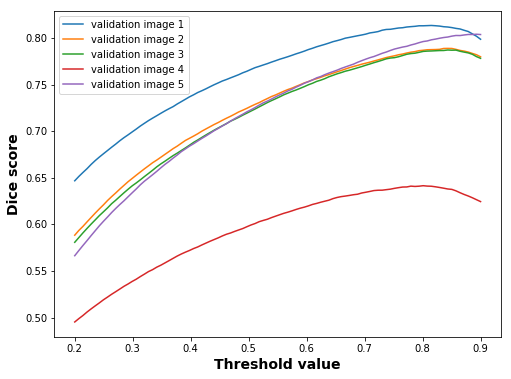

In [11]:
plt.rcParams["figure.figsize"] = (8,6)
for num_img in range(5):
    plt.plot(limit, dice_lists[num_img], label="validation image {}".format(num_img+1))
    
plt.legend()
plt.xlabel("Threshold value", fontsize=14, fontweight="bold")
plt.ylabel("Dice score", fontsize=14, fontweight="bold")
plt.show()

In [12]:
opt_limit_list = []
for i, dice_list in enumerate(dice_lists):
    max_index = np.argmax(dice_list)
    print("Maximum dice score: ", dice_list[max_index])
    print("Threshold for maximum dice score: ", limit[max_index])
    print("Absolute value threshold: ", limit[max_index]*np.amax(probimage[i]) )
    print("\n")
    opt_limit_list.append(limit[max_index])

Maximum dice score:  0.8133997078387156
Threshold for maximum dice score:  0.8151515151515152
Absolute value threshold:  0.8151228489297809


Maximum dice score:  0.7887937291334011
Threshold for maximum dice score:  0.8434343434343434
Absolute value threshold:  0.8434160442063302


Maximum dice score:  0.787071856896026
Threshold for maximum dice score:  0.8434343434343434
Absolute value threshold:  0.8434221774640709


Maximum dice score:  0.6414473684210527
Threshold for maximum dice score:  0.801010101010101
Absolute value threshold:  0.800982027583652


Maximum dice score:  0.8039875907990315
Threshold for maximum dice score:  0.8929292929292929
Absolute value threshold:  0.8929028944535689




In [13]:
opt_limit = np.mean(opt_limit_list)
print("Average optimal limit: ", opt_limit)

Average optimal limit:  0.8391919191919193


# Apply the optimal limit (threshold) to the test set

In [14]:
foldername = "./results/submission04_results/test_results/"
fnames = glob.glob(foldername + '*.npy')
print(fnames)

['./results/submission04_results/test_results\\test_probabilities_1.npy', './results/submission04_results/test_results\\test_probabilities_10.npy', './results/submission04_results/test_results\\test_probabilities_11.npy', './results/submission04_results/test_results\\test_probabilities_12.npy', './results/submission04_results/test_results\\test_probabilities_13.npy', './results/submission04_results/test_results\\test_probabilities_14.npy', './results/submission04_results/test_results\\test_probabilities_15.npy', './results/submission04_results/test_results\\test_probabilities_16.npy', './results/submission04_results/test_results\\test_probabilities_17.npy', './results/submission04_results/test_results\\test_probabilities_18.npy', './results/submission04_results/test_results\\test_probabilities_19.npy', './results/submission04_results/test_results\\test_probabilities_2.npy', './results/submission04_results/test_results\\test_probabilities_20.npy', './results/submission04_results/test_re

In [15]:
test_probimages = []
test_images_sequence = []
for fname in fnames:
    test_probimages.append(np.load(fname))
    test_images_sequence.append(fname.split('_')[-1].split('.')[0])

print(len(test_probimages))
print(test_images_sequence)

# Rearange fnames
test_images_sequence = np.array(test_images_sequence, dtype=int)
sort_ind = np.argsort(test_images_sequence)
fnames = np.array(fnames)
fnames = fnames[sort_ind]
test_probimages = np.array(test_probimages)
test_probimages = test_probimages[sort_ind]

20
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']


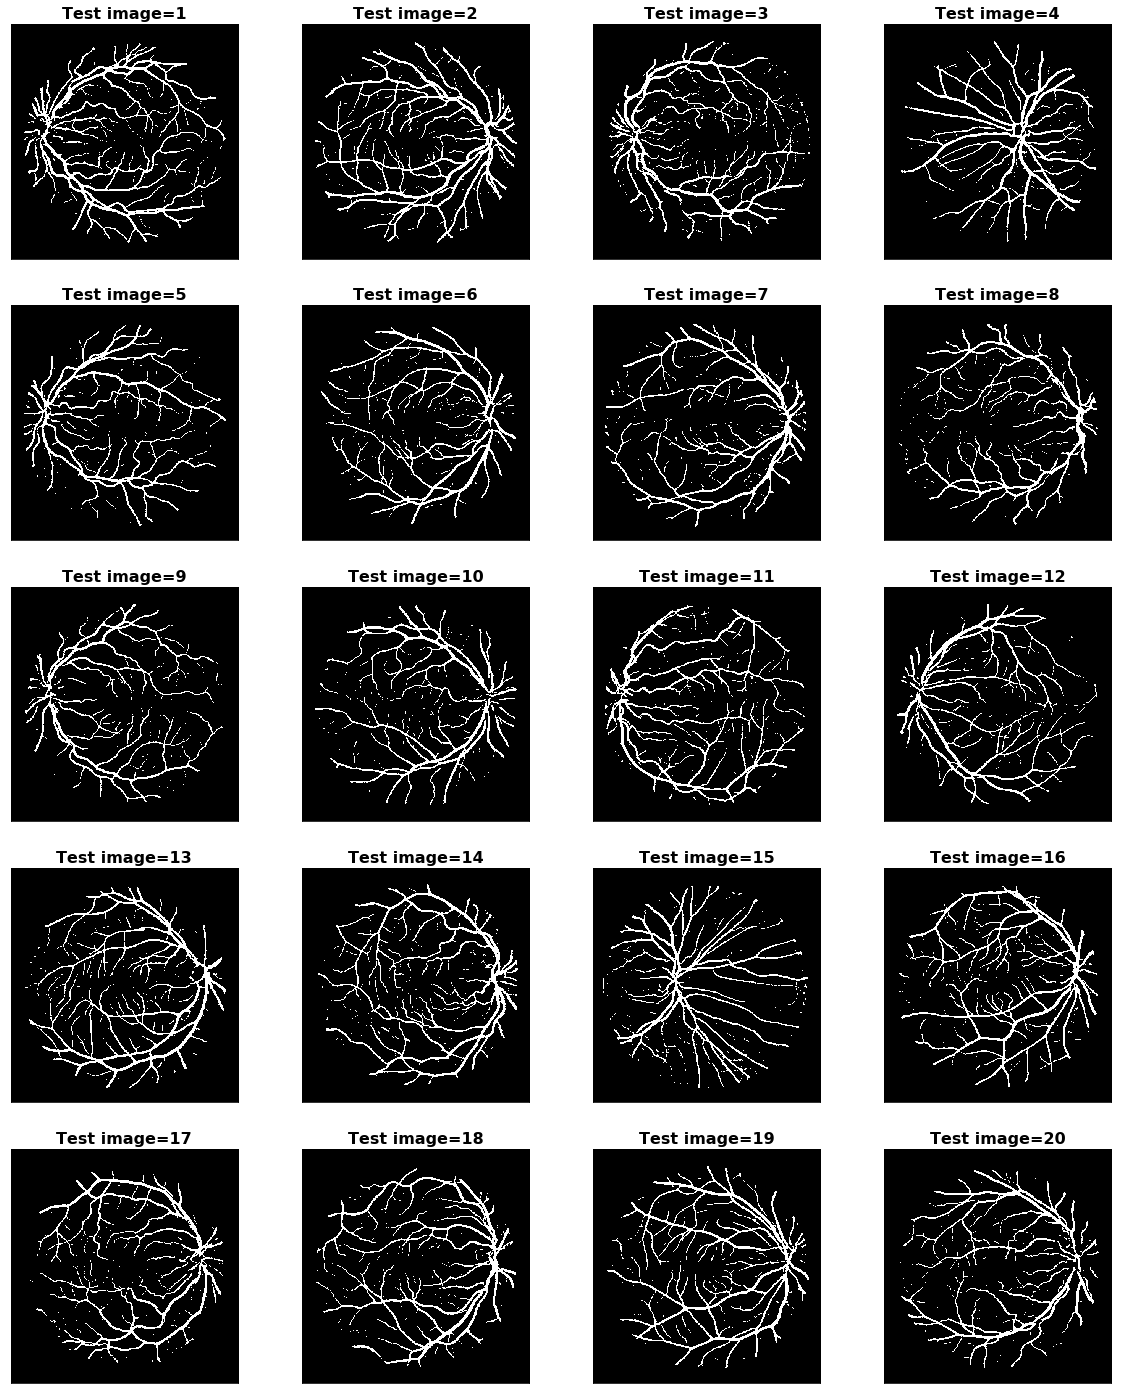

In [17]:
plt.rcParams["figure.figsize"] = (20,25)

nrows = 5
ncols = 4

# Thresholded test images
for i in range(len(test_probimages)):
    plt.subplot(nrows, ncols, i+1)
    thres_image = copy.deepcopy(test_probimages[i])
    thres_image[thres_image>opt_limit*np.amax(test_probimages[i])] = 1
    thres_image[thres_image<=opt_limit*np.amax(test_probimages[i])] = 0
    plt.imshow(thres_image, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    which_image = fnames[i].split('_')[-1].split('.')[0]
    plt.title(f"Test image={which_image}", fontsize=16, fontweight="bold")
    
    # Save each image as PNG file
    img = PIL.Image.fromarray(np.uint8(thres_image[16:-16,16:-16]*255))
    img.save("./submission/{}.png".format(i+1), "PNG")
    
plt.show()

In [26]:
np.unique(probimage)

array([0.00000000e+00, 6.35031101e-05, 6.70509253e-05, ...,
       9.99981642e-01, 9.99981999e-01, 9.99982953e-01])